NoiseType1 Spectogram initially

Processing: NoiseType1.wav


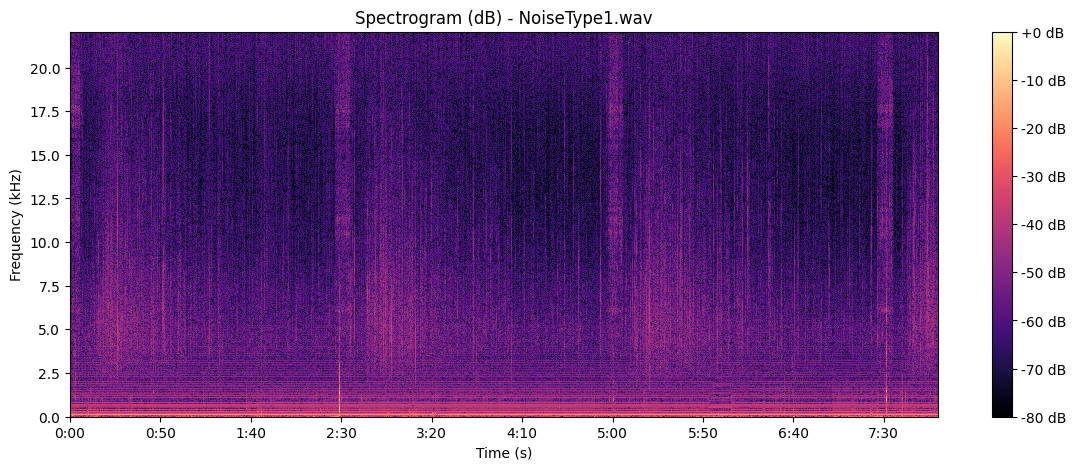

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

def plot_spectrogram(audio_path):
    """
    Plot the spectrogram of an audio file without log scale and with frequency in kHz.
    """
    print(f"Processing: {audio_path}")
    
    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)

    # Compute the Short-Time Fourier Transform (STFT) and convert to dB
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

    # Plot spectrogram
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear')  # Use linear scale
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram (dB) - {audio_path}')
    
    # Customize y-axis to display in kHz
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x / 1000:.1f}'))
    plt.ylabel('Frequency (kHz)')
    plt.xlabel('Time (s)')
    plt.show()

# Example usage
if __name__ == "__main__":
    audio_file = "NoiseType1.wav"  # Replace with the actual file path
    plot_spectrogram(audio_file)

Static noise removal (Spectral Subtraction, Wavelet denoising)

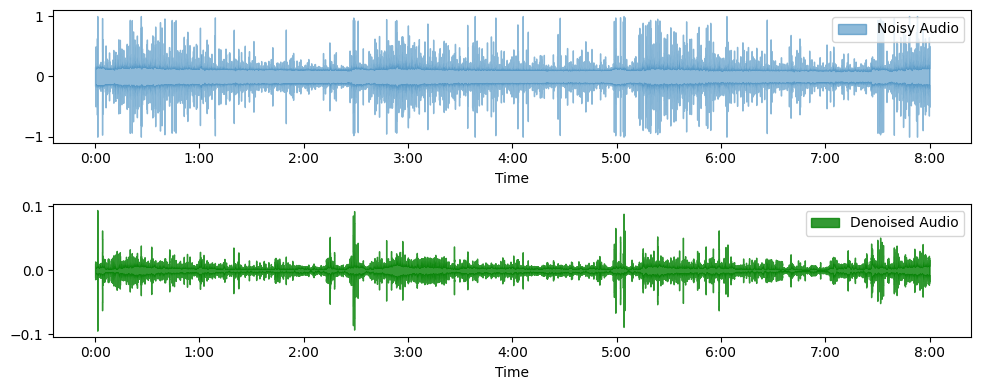

Denoised audio saved as: modified_audio.wav


In [1]:
import numpy as np
import librosa
import librosa.display
import scipy.signal as signal
import pywt
import soundfile as sf
import matplotlib.pyplot as plt

# Load the noisy audio file
audio_path = "NoiseType1.wav"  # Change to your file path
y, sr = librosa.load(audio_path, sr=None)

# Step 1: Estimate Noise Profile (Using Initial Silence)
def estimate_noise(y, noise_duration=0.5, sr=22050):
    noise_samples = int(noise_duration * sr)
    noise_profile = y[:noise_samples]
    return np.mean(np.abs(librosa.stft(noise_profile)), axis=1)

# Step 2: Spectral Subtraction
def spectral_subtraction(y, sr):
    noise_profile = estimate_noise(y, sr=sr)
    S = np.abs(librosa.stft(y))
    S_denoised = np.maximum(S - noise_profile[:, np.newaxis], 0)  # Subtract noise
    return librosa.istft(S_denoised)

# Step 3: Wavelet Denoising
def wavelet_denoise(y, wavelet="db4", level=4):
    coeffs = pywt.wavedec(y, wavelet, level=level)
    threshold = np.median(np.abs(coeffs[-1])) / 0.6745
    coeffs_thresholded = [pywt.threshold(c, threshold, mode="soft") for c in coeffs]
    return pywt.waverec(coeffs_thresholded, wavelet)

# Apply noise reduction techniques
y_spectral = spectral_subtraction(y, sr)
y_denoised = wavelet_denoise(y_spectral)

# Save the cleaned audio
output_path = "modified_audio.wav"
sf.write(output_path, y_denoised, sr)

# Plot Before and After
plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr, alpha=0.5, label="Noisy Audio")
plt.legend()

plt.subplot(2, 1, 2)
librosa.display.waveshow(y_denoised, sr=sr, alpha=0.8, color="green", label="Denoised Audio")
plt.legend()

plt.tight_layout()
plt.show()

print(f"Denoised audio saved as: {output_path}")


Spectogram after static noise removal

Processing: modified_audio.wav


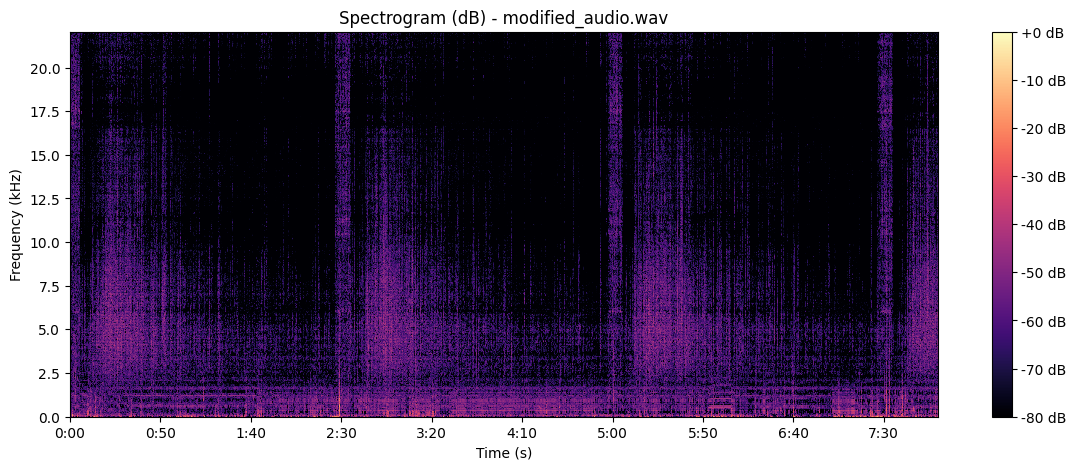

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

def plot_spectrogram(audio_path):
    """
    Plot the spectrogram of an audio file without log scale and with frequency in kHz.
    """
    print(f"Processing: {audio_path}")
    
    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)

    # Compute the Short-Time Fourier Transform (STFT) and convert to dB
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

    # Plot spectrogram
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear')  # Use linear scale
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram (dB) - {audio_path}')
    
    # Customize y-axis to display in kHz
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x / 1000:.1f}'))
    plt.ylabel('Frequency (kHz)')
    plt.xlabel('Time (s)')
    plt.show()

# Example usage
if __name__ == "__main__":
    audio_file = "modified_audio.wav"  # Replace with the actual file path
    plot_spectrogram(audio_file)

Using extra noise removal (notch filter, time frequency masking, wavelet)

c:\Users\Nithin Kodipyaka\AppData\Local\Programs\Python\Python310\lib\site-packages\pywt\_thresholding.py:22: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)


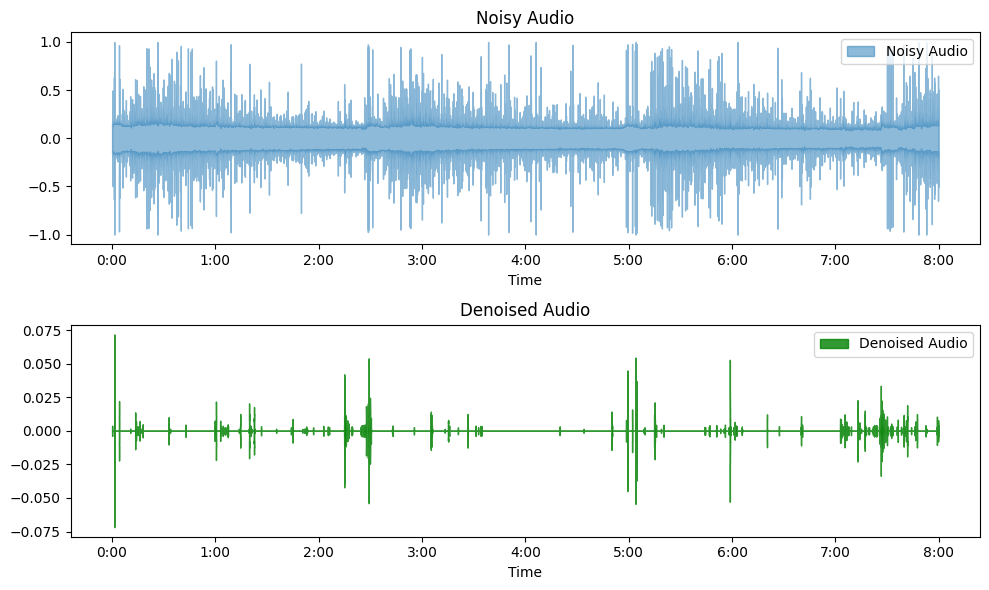

Denoised audio saved as: modified_audio2.wav


In [8]:
import numpy as np
import librosa
import librosa.display
import scipy.signal as signal
import pywt
import soundfile as sf
import matplotlib.pyplot as plt

# Load the noisy audio file
audio_path = "NoiseType1.wav"  # Change to your file path
y, sr = librosa.load(audio_path, sr=None)

# Step 1: Estimate Noise Profile (Using Initial Silence)
def estimate_noise(y, noise_duration=0.5, sr=22050):
    noise_samples = int(noise_duration * sr)
    noise_profile = y[:noise_samples]  # Assuming the first 0.5 seconds are noise
    return np.mean(np.abs(librosa.stft(noise_profile)), axis=1)

# Step 2: Spectral Subtraction
def spectral_subtraction(y, sr):
    noise_profile = estimate_noise(y, sr=sr)
    S = np.abs(librosa.stft(y))
    S_denoised = np.maximum(S - noise_profile[:, np.newaxis], 0)  # Subtract noise
    return librosa.istft(S_denoised)

# Step 3: Adaptive Notch Filtering (Frequency Band Suppression)
def adaptive_notch_filter(y, sr, f0=50, bandwidth=5):
    nyquist = sr / 2
    f0_norm = f0 / nyquist  # Normalize frequency
    b, a = signal.iirnotch(f0_norm, bandwidth, sr)
    y_filtered = signal.filtfilt(b, a, y)
    return y_filtered

# Step 4: Time-Frequency Masking Using Spectrogram Analysis
def time_frequency_masking(y, sr, threshold=0.1):
    S = librosa.stft(y)
    magnitude, phase = np.abs(S), np.angle(S)
    noise_threshold = threshold * np.max(magnitude)
    mask = magnitude > noise_threshold
    S_masked = magnitude * mask * np.exp(1j * phase)
    return librosa.istft(S_masked)

# Step 5: Wavelet Transformation (Decomposition and Thresholding)
def wavelet_denoise(y, wavelet="db4", level=4):
    coeffs = pywt.wavedec(y, wavelet, level=level)
    threshold = np.median(np.abs(coeffs[-1])) / 0.6745
    coeffs_thresholded = []
    for c in coeffs:
        # Avoid invalid values during thresholding
        magnitude = np.abs(c)
        thresholded = np.where(magnitude > 0, pywt.threshold(c, threshold, mode="soft"), 0)
        coeffs_thresholded.append(thresholded)
    return pywt.waverec(coeffs_thresholded, wavelet)

# Apply noise reduction techniques
# 1. Spectral Subtraction
y_spectral = spectral_subtraction(y, sr)

# 2. Adaptive Notch Filtering
y_notch_filtered = adaptive_notch_filter(y_spectral, sr)

# 3. Time-Frequency Masking
y_masked = time_frequency_masking(y_notch_filtered, sr)

# 4. Wavelet Transformation
y_denoised = wavelet_denoise(y_masked)

# Ensure the audio buffer is finite
y_denoised = np.nan_to_num(y_denoised, nan=0.0, posinf=0.0, neginf=0.0)

# Save the cleaned audio
output_path = "modified_audio2.wav"
sf.write(output_path, y_denoised, sr)

# Plot Before and After
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr, alpha=0.5, label="Noisy Audio")
plt.legend()
plt.title("Noisy Audio")

plt.subplot(2, 1, 2)
librosa.display.waveshow(y_denoised, sr=sr, alpha=0.8, color="green", label="Denoised Audio")
plt.legend()
plt.title("Denoised Audio")

plt.tight_layout()
plt.show()

print(f"Denoised audio saved as: {output_path}")

Became way too clean by removing necessary sounds too

Notch Filtering

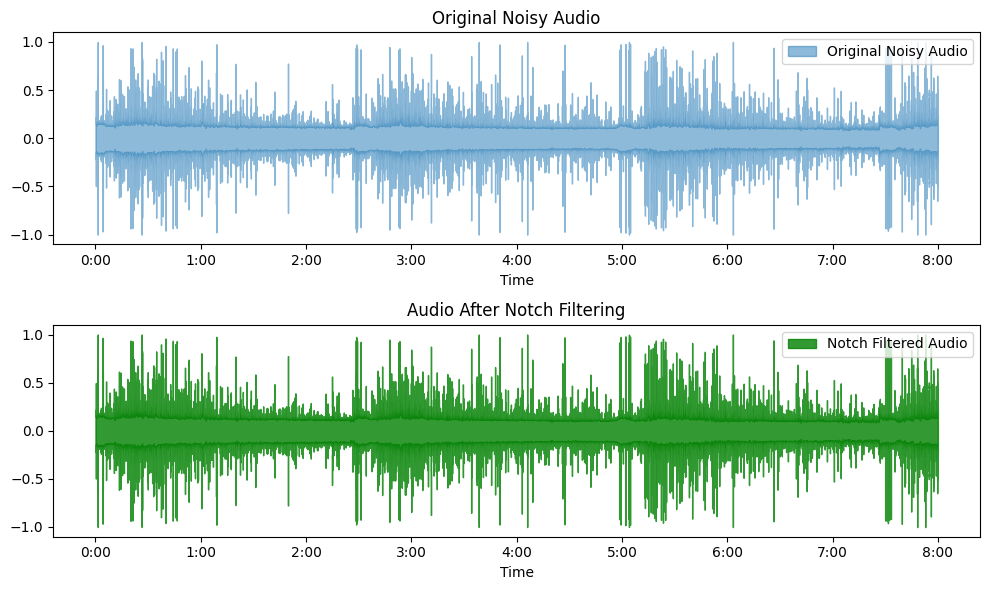

Notch-filtered audio saved as: notch_filtered_audio.wav


In [10]:
import numpy as np
import librosa
import librosa.display
import scipy.signal as signal
import soundfile as sf
import matplotlib.pyplot as plt

# Load the noisy audio file
audio_path = "NoiseType1.wav"  # Change to your file path
y, sr = librosa.load(audio_path, sr=None)

# Step 1: Adaptive Notch Filtering (Frequency Band Suppression)
def adaptive_notch_filter(y, sr, f0=50, bandwidth=10):
    nyquist = sr / 2
    f0_norm = f0 / nyquist  # Normalize frequency
    b, a = signal.iirnotch(f0_norm, bandwidth, sr)
    y_filtered = signal.filtfilt(b, a, y)
    return y_filtered

# Apply notch filter to suppress static noise
y_notch_filtered = adaptive_notch_filter(y, sr, f0=60, bandwidth=30)  # Modify f0 as needed for your noise frequency

# Save the filtered audio
notch_output_path = "notch_filtered_audio.wav"
sf.write(notch_output_path, y_notch_filtered, sr)

# Plot Before and After
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr, alpha=0.5, label="Original Noisy Audio")
plt.legend()
plt.title("Original Noisy Audio")

plt.subplot(2, 1, 2)
librosa.display.waveshow(y_notch_filtered, sr=sr, alpha=0.8, color="green", label="Notch Filtered Audio")
plt.legend()
plt.title("Audio After Notch Filtering")

plt.tight_layout()
plt.show()

print(f"Notch-filtered audio saved as: {notch_output_path}")


Adaptive notch filtering is designed to target a very specific frequency or a narrow band of frequencies (e.g., 50Hz, 60Hz hum, or harmonics of power line noise). If the static noise (e.g., "zzzz") spans a wide frequency range, the notch filter won't make a dramatic difference because it's only addressing a narrow range.

If the noise in your audio is broadband or more complex, other techniques, like Time-Frequency Masking or Wavelet Denoising, will make a bigger impact.

Time Frequency masking

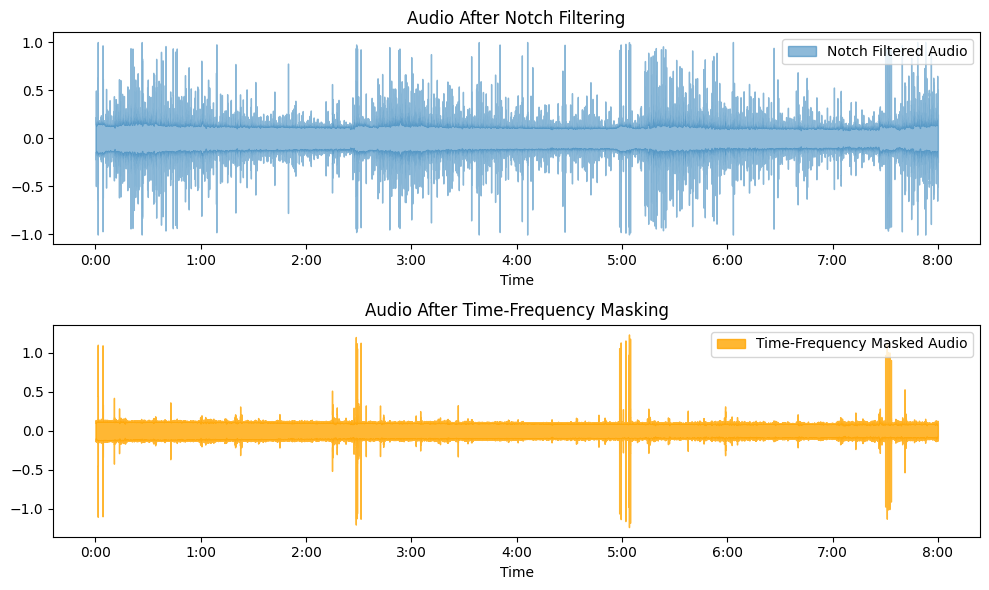

Time-frequency masked audio saved as: time_frequency_masked_audio.wav


In [16]:
# Step 2: Time-Frequency Masking Using Spectrogram Analysis
def time_frequency_masking(y, sr, threshold=0.05):
    """
    Suppresses noise in time-frequency regions using a spectrogram mask.
    - `threshold`: Noise suppression threshold relative to the max amplitude.
    """
    # Compute the short-time Fourier transform (STFT)
    S = librosa.stft(y)
    magnitude, phase = np.abs(S), np.angle(S)
    
    # Calculate noise threshold
    noise_threshold = threshold * np.max(magnitude)
    
    # Create a mask to retain only significant amplitudes
    mask = magnitude > noise_threshold
    
    # Apply the mask and reconstruct the signal
    S_masked = magnitude * mask * np.exp(1j * phase)
    return librosa.istft(S_masked)

# Apply time-frequency masking to the notch-filtered audio
y_masked = time_frequency_masking(y_notch_filtered, sr, threshold=0.03)

# Save the masked audio
masked_output_path = "time_frequency_masked_audio.wav"
sf.write(masked_output_path, y_masked, sr)

# Plot Before and After
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
librosa.display.waveshow(y_notch_filtered, sr=sr, alpha=0.5, label="Notch Filtered Audio")
plt.legend()
plt.title("Audio After Notch Filtering")

plt.subplot(2, 1, 2)
librosa.display.waveshow(y_masked, sr=sr, alpha=0.8, color="orange", label="Time-Frequency Masked Audio")
plt.legend()
plt.title("Audio After Time-Frequency Masking")

plt.tight_layout()
plt.show()

print(f"Time-frequency masked audio saved as: {masked_output_path}")


This shows good result, but the graph indicates that the static noise is still there, but it removed other neighburing noises. lets see spectogram of this audio

Processing: time_frequency_masked_audio.wav


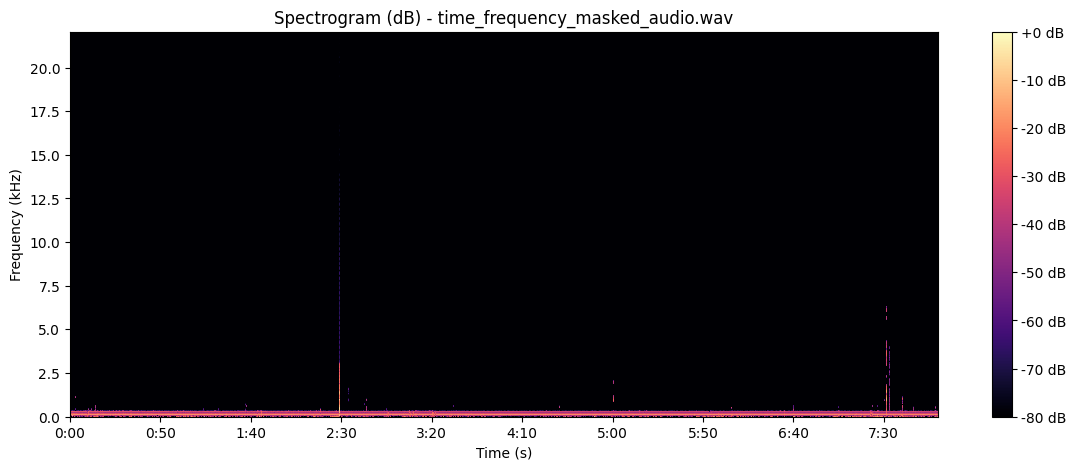

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

def plot_spectrogram(audio_path):
    """
    Plot the spectrogram of an audio file without log scale and with frequency in kHz.
    """
    print(f"Processing: {audio_path}")
    
    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)

    # Compute the Short-Time Fourier Transform (STFT) and convert to dB
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

    # Plot spectrogram
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear')  # Use linear scale
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram (dB) - {audio_path}')
    
    # Customize y-axis to display in kHz
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x / 1000:.1f}'))
    plt.ylabel('Frequency (kHz)')
    plt.xlabel('Time (s)')
    plt.show()

# Example usage
if __name__ == "__main__":
    audio_file = "time_frequency_masked_audio.wav"  # Replace with the actual file path
    plot_spectrogram(audio_file)

Wavelet denoising

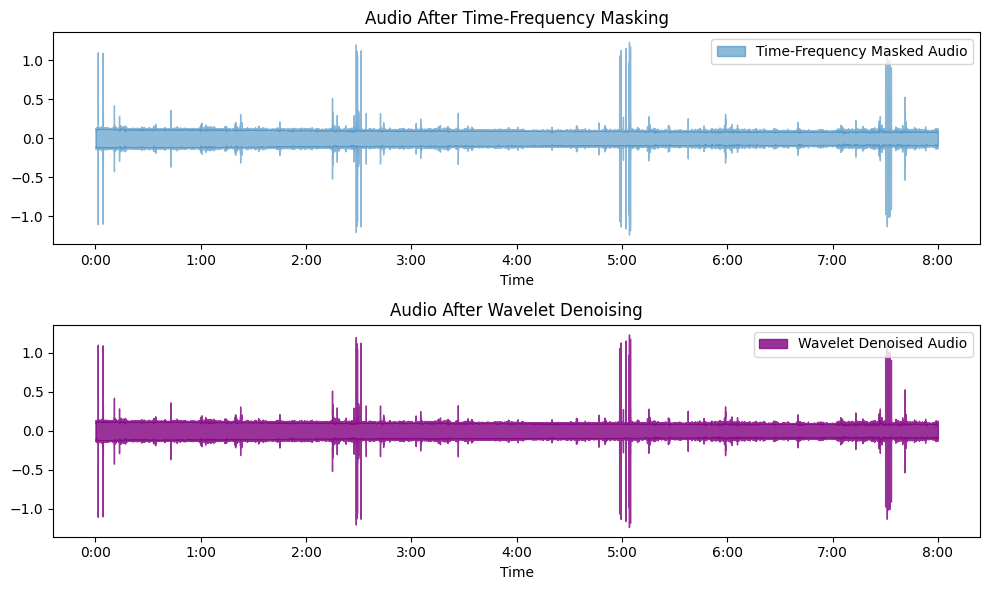

Wavelet denoised audio saved as: wavelet_denoised_audio.wav


In [20]:
# Step 3: Wavelet Denoising
def wavelet_denoise(y, wavelet="db4", level=4):
    """
    Perform wavelet denoising on the audio signal.
    - `wavelet`: The type of wavelet to use.
    - `level`: Number of decomposition levels.
    """
    # Decompose the signal using discrete wavelet transform (DWT)
    coeffs = pywt.wavedec(y, wavelet, level=level)
    
    # Estimate a threshold based on the noise level
    threshold = np.median(np.abs(coeffs[-1])) / 0.6745  # Universal threshold
    
    # Apply soft thresholding to each coefficient
    coeffs_thresholded = [pywt.threshold(c, threshold, mode="soft") for c in coeffs]
    
    # Reconstruct the signal from thresholded coefficients
    return pywt.waverec(coeffs_thresholded, wavelet)

# Apply wavelet denoising to the time-frequency masked audio
y_wavelet_denoised = wavelet_denoise(y_masked)

# Ensure the audio buffer is finite (avoid invalid values)
y_wavelet_denoised = np.nan_to_num(y_wavelet_denoised, nan=0.0, posinf=0.0, neginf=0.0)

# Save the wavelet denoised audio
wavelet_output_path = "wavelet_denoised_audio.wav"
sf.write(wavelet_output_path, y_wavelet_denoised, sr)

# Plot Before and After
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
librosa.display.waveshow(y_masked, sr=sr, alpha=0.5, label="Time-Frequency Masked Audio")
plt.legend()
plt.title("Audio After Time-Frequency Masking")

plt.subplot(2, 1, 2)
librosa.display.waveshow(y_wavelet_denoised, sr=sr, alpha=0.8, color="purple", label="Wavelet Denoised Audio")
plt.legend()
plt.title("Audio After Wavelet Denoising")

plt.tight_layout()
plt.show()

print(f"Wavelet denoised audio saved as: {wavelet_output_path}")


Not much difference, best audio as of now is Modified_audio.wav with removed noise but retained other features.
Time frequency masked audio and modified_audio2.wav removed noise completely, but also removed other features along with it.

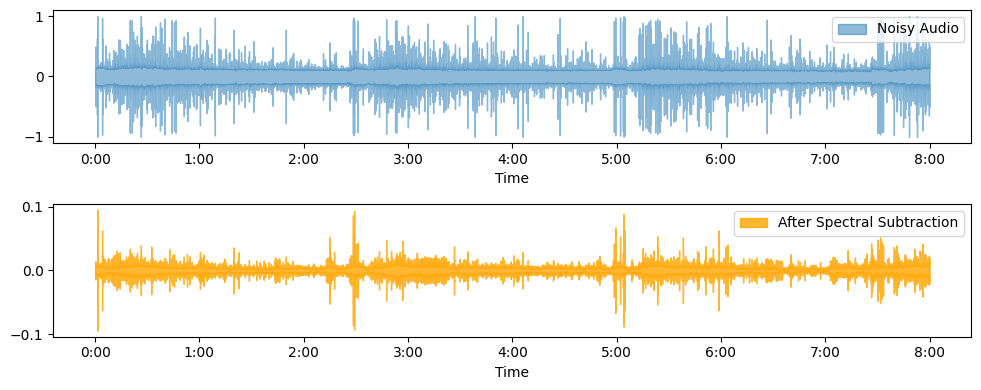

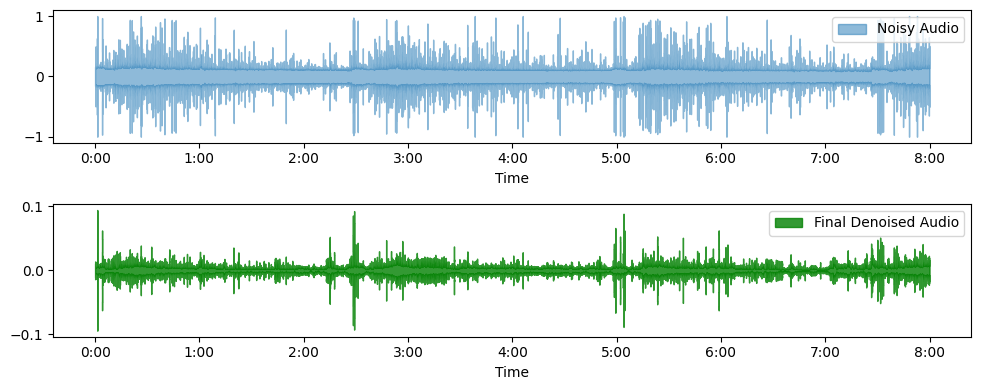

Denoised audio saved as: modified_audio.wav


In [3]:
import numpy as np
import librosa
import librosa.display
import scipy.signal as signal
import pywt
import soundfile as sf
import matplotlib.pyplot as plt

# Load the noisy audio file
audio_path = "NoiseType1.wav"  # Change to your file path
y, sr = librosa.load(audio_path, sr=None)

# Step 1: Estimate Noise Profile (Using Initial Silence)
def estimate_noise(y, noise_duration=0.5, sr=22050):
    noise_samples = int(noise_duration * sr)
    noise_profile = y[:noise_samples]
    return np.mean(np.abs(librosa.stft(noise_profile)), axis=1)

# Step 2: Spectral Subtraction
def spectral_subtraction(y, sr):
    noise_profile = estimate_noise(y, sr=sr)
    S = np.abs(librosa.stft(y))
    S_denoised = np.maximum(S - noise_profile[:, np.newaxis], 0)  # Subtract noise
    return librosa.istft(S_denoised)

# Step 3: Wavelet Denoising
def wavelet_denoise(y, wavelet="db4", level=4):
    coeffs = pywt.wavedec(y, wavelet, level=level)
    threshold = np.median(np.abs(coeffs[-1])) / 0.6745
    coeffs_thresholded = [pywt.threshold(c, threshold, mode="soft") for c in coeffs]
    return pywt.waverec(coeffs_thresholded, wavelet)

# Apply spectral subtraction
y_spectral = spectral_subtraction(y, sr)

# Plot Before and After Spectral Subtraction
plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr, alpha=0.5, label="Noisy Audio")
plt.legend()

plt.subplot(2, 1, 2)
librosa.display.waveshow(y_spectral, sr=sr, alpha=0.8, color="orange", label="After Spectral Subtraction")
plt.legend()

plt.tight_layout()
plt.show()

# Apply wavelet denoising
y_denoised = wavelet_denoise(y_spectral)

# Save the cleaned audio
output_path = "modified_audio.wav"
sf.write(output_path, y_denoised, sr)

# Plot Final Comparison
plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr, alpha=0.5, label="Noisy Audio")
plt.legend()

plt.subplot(2, 1, 2)
librosa.display.waveshow(y_denoised, sr=sr, alpha=0.8, color="green", label="Final Denoised Audio")
plt.legend()

plt.tight_layout()
plt.show()

print(f"Denoised audio saved as: {output_path}")
